In [1]:
import os
import pandas as pd
import numpy as np

import torch
import transformers
from transformers import *

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

print(f'torch version: {torch.__version__}')
print(f'transformers version: {transformers.__version__}')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


torch version: 1.6.0
transformers version: 3.0.2


In [2]:
data_dir = "/kaggle/input/google-quest-challenge/"

train = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')
sub = pd.read_csv(data_dir + 'sample_submission.csv')

In [3]:
train.shape, test.shape, sub.shape

((6079, 41), (476, 11), (476, 31))

In [4]:
test.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host'],
      dtype='object')

In [5]:
sub.columns

Index(['qa_id', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

# Number of words/tokens distributions

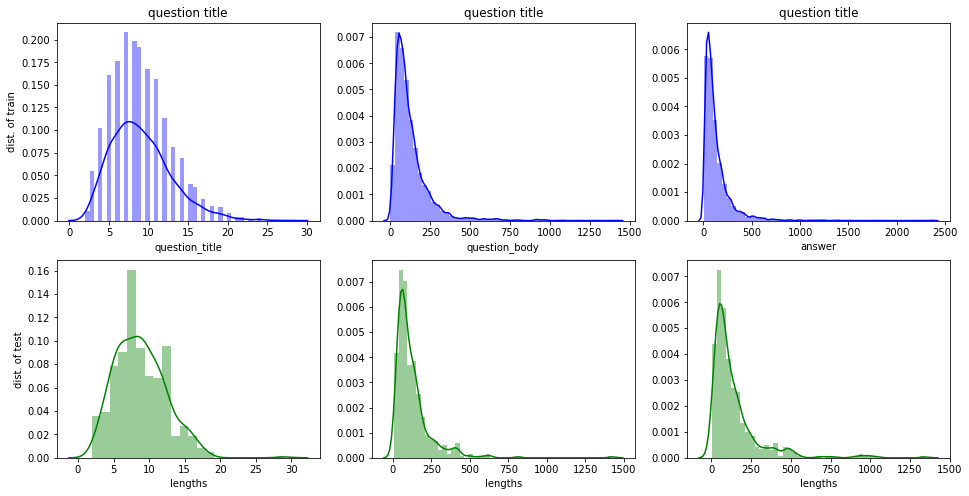

In [6]:
plt.subplots(figsize=(16, 8))

ax = plt.subplot(231)
sns.distplot(train.question_title.str.split().apply(len), color='b', ax=ax)
ax.set_title('question title')
ax.set_ylabel('dist. of train')

ax = plt.subplot(232)
sns.distplot(train.question_body.str.split().apply(len), color='b', ax=ax)
ax.set_title('question title')

ax = plt.subplot(233)
sns.distplot(train.answer.str.split().apply(len), color='b', ax=ax)
ax.set_title('question title')

ax = plt.subplot(234)
sns.distplot(test.question_title.str.split().apply(len), color='g', ax=ax)
ax.set_xlabel('lengths')
ax.set_ylabel('dist. of test')

ax = plt.subplot(235)
sns.distplot(test.question_body.str.split().apply(len), color='g', ax=ax)
ax.set_xlabel('lengths')

ax = plt.subplot(236)
sns.distplot(test.answer.str.split().apply(len), color='g', ax=ax)
ax.set_xlabel('lengths')

plt.show()

In [7]:
feature_cols = ['question_title', 'question_body', 'answer']
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

trn_qtitle = tokenizer.batch_encode_plus(train[feature_cols[0]])['input_ids']
trn_qbody = tokenizer.batch_encode_plus(train[feature_cols[1]])['input_ids']
trn_ans = tokenizer.batch_encode_plus(train[feature_cols[2]])['input_ids']

ts_qtitle = tokenizer.batch_encode_plus(test[feature_cols[0]])['input_ids']
ts_qbody = tokenizer.batch_encode_plus(test[feature_cols[1]])['input_ids']
ts_ans = tokenizer.batch_encode_plus(test[feature_cols[2]])['input_ids']

In [8]:
trn_qtitle_len = list(map(len, trn_qtitle))
trn_qbody_len = list(map(len, trn_qbody))
trn_ans_len = list(map(len, trn_ans))

ts_qtitle_len = list(map(len, ts_qtitle))
ts_qbody_len = list(map(len, ts_qbody))
ts_ans_len = list(map(len, ts_ans))

print(f'max len of train qtitle: {max(trn_qtitle_len)}')
print(f'max len of train qbody: {max(trn_qbody_len)}')
print(f'max len of train ans: {max(trn_ans_len)}')
print(f'max len of test qtitle: {max(ts_qtitle_len)}')
print(f'max len of test qbody: {max(ts_qbody_len)}')
print(f'max len of test ans: {max(ts_ans_len)}')

max len of train qtitle: 65
max len of train qbody: 6851
max len of train ans: 9321
max len of test qtitle: 57
max len of test qbody: 3565
max len of test ans: 2759


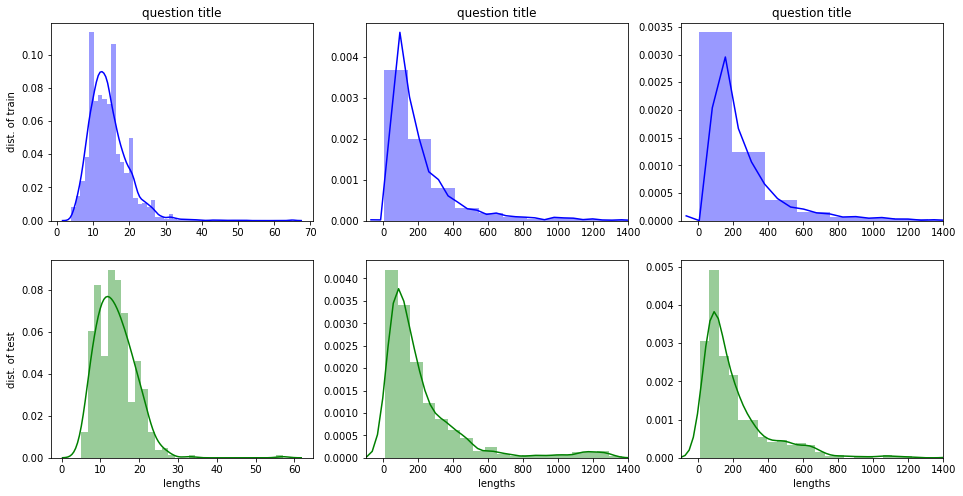

In [9]:
plt.subplots(figsize=(16, 8))

ax = plt.subplot(231)
sns.distplot(trn_qtitle_len, color='b', ax=ax)
ax.set_title('question title')
ax.set_ylabel('dist. of train')

ax = plt.subplot(232)
sns.distplot(trn_qbody_len, color='b', ax=ax)
ax.set_xlim([-100, 1400])
ax.set_title('question title')

ax = plt.subplot(233)
sns.distplot(trn_ans_len, color='b', ax=ax)
ax.set_xlim([-100, 1400])
ax.set_title('question title')

ax = plt.subplot(234)
sns.distplot(ts_qtitle_len, color='g', ax=ax)
ax.set_xlabel('lengths')
ax.set_ylabel('dist. of test')

ax = plt.subplot(235)
sns.distplot(ts_qbody_len, color='g', ax=ax)
ax.set_xlim([-100, 1400])
ax.set_xlabel('lengths')

ax = plt.subplot(236)
sns.distplot(ts_ans_len, color='g', ax=ax)
ax.set_xlim([-100, 1400])
ax.set_xlabel('lengths')

plt.show()

# Distribution of targets

In [10]:
target_cols = list(sub.columns)[1:]

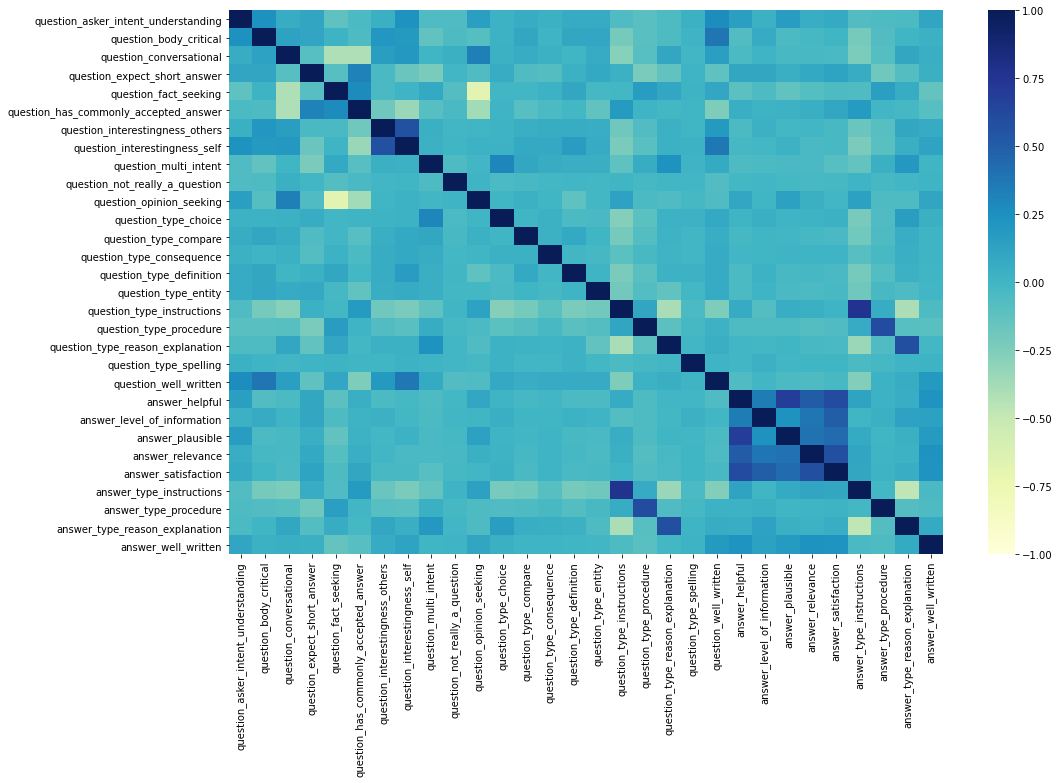

In [11]:
plt.figure(figsize=(16,10))
sns.heatmap(train[target_cols].corr(),vmin=-1,cmap='YlGnBu');

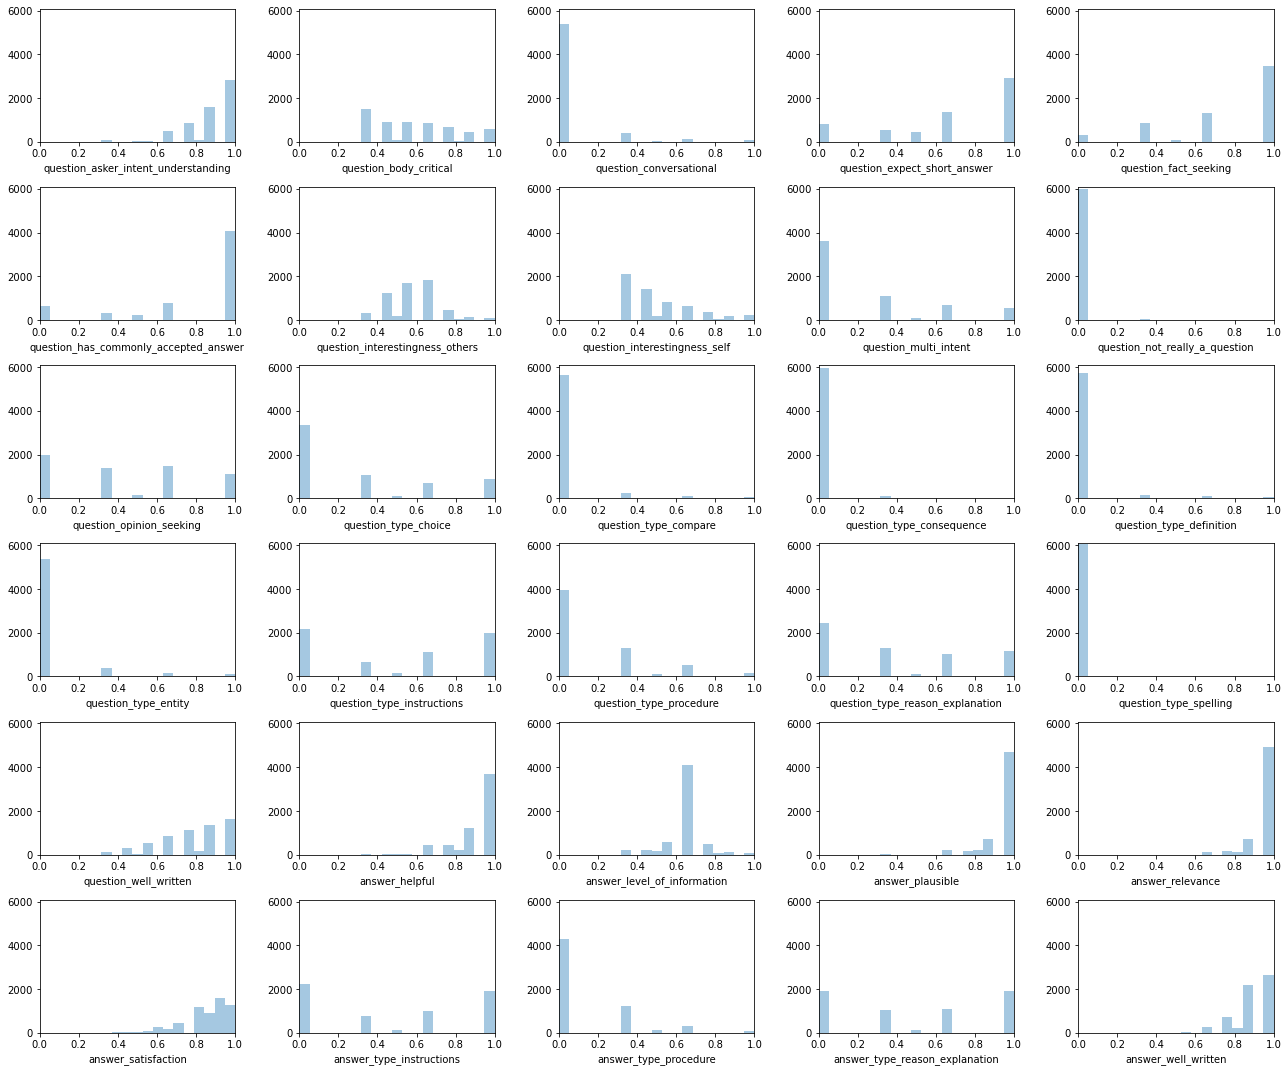

In [12]:
fig, axes = plt.subplots(6, 5, figsize=(18, 15))
axes = axes.ravel()
bins = np.linspace(0, 1, 20)

for i, col in enumerate(target_cols):
    ax = axes[i]
    sns.distplot(train[col], label=col, kde=False, bins=bins, ax=ax)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 6079])

plt.tight_layout()
plt.show()